## An Experimental Exploratory Data Analysis Pipeline

#### From Visualization to Feature Engineering 

#### From Feature Selection to Best Model Selection



### Prepare Workspace

In [0]:
# Upload libraries
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.formula.api import ols
import itertools

In [0]:
# Upload dataset
url ='https://raw.githubusercontent.com/claudio1975/100DaysOfDataScienceProjects/master/An%20Experimental%20Exploratory%20Data%20Analysis%20Pipeline/data/CAX_MortgageModeling_Train.csv'
df = pd.read_csv(url)

In [0]:
# Split dataset between target and features
X_full = df
y = X_full.RESULT
X_full.drop(['RESULT'], axis=1, inplace=True)


**Summarize Data**

In [68]:
# dimensions of dataset
print(X_full.shape)

(45642, 21)


In [69]:
# list types for each attribute
X_full.dtypes

Unique_ID             object
MORTGAGE NUMBER        int64
PROPERTY VALUE         int64
MORTGAGE PAYMENT       int64
GDS                  float64
LTV                  float64
TDS                  float64
AMORTIZATION           int64
MORTGAGE AMOUNT      float64
RATE                 float64
MORTGAGE PURPOSE      object
PAYMENT FREQUENCY     object
PROPERTY TYPE         object
TERM                   int64
FSA                   object
AGE RANGE             object
GENDER                object
INCOME                 int64
INCOME TYPE            int64
NAICS CODE            object
CREDIT SCORE           int64
dtype: object

In [70]:
# take a peek at the first rows of the data
X_full.head(5)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709
3,CAX_Train_4,4,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761
4,CAX_Train_5,5,350000,3342,29.59,80.00,34.85,360,592000.0,5.0,Refinance,Monthly,Single Detached,12,L7G,50-54,Male,147000,8,62,762


In [71]:
# summarize attribute distributions for data frame
print(X_full.describe().T)

                    count           mean  ...        75%         max
MORTGAGE NUMBER   45642.0   22821.500000  ...   34231.75     45642.0
PROPERTY VALUE    45642.0  582611.038079  ...  685000.00  18000000.0
MORTGAGE PAYMENT  45642.0    2392.148043  ...    2866.00     46479.0
GDS               45642.0     213.803294  ...      35.87   6872300.0
LTV               45642.0      70.632932  ...      80.00        95.0
TDS               45642.0     412.566952  ...      42.17  13462562.5
AMORTIZATION      45642.0     355.309583  ...     360.00       480.0
MORTGAGE AMOUNT   45642.0  425570.446942  ...  512000.00   7500000.0
RATE              45642.0       4.651149  ...       5.00        10.0
TERM              45642.0      15.286578  ...      12.00        60.0
INCOME            45642.0  125109.307217  ...  145000.00   3860000.0
INCOME TYPE       45642.0       5.315017  ...       8.00        20.0
CREDIT SCORE      45642.0     662.662811  ...     736.00       899.0

[13 rows x 8 columns]


In [72]:
print(X_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 21 columns):
Unique_ID            45642 non-null object
MORTGAGE NUMBER      45642 non-null int64
PROPERTY VALUE       45642 non-null int64
MORTGAGE PAYMENT     45642 non-null int64
GDS                  45642 non-null float64
LTV                  45642 non-null float64
TDS                  45642 non-null float64
AMORTIZATION         45642 non-null int64
MORTGAGE AMOUNT      45642 non-null float64
RATE                 45642 non-null float64
MORTGAGE PURPOSE     45642 non-null object
PAYMENT FREQUENCY    45642 non-null object
PROPERTY TYPE        45642 non-null object
TERM                 45642 non-null int64
FSA                  45642 non-null object
AGE RANGE            45642 non-null object
GENDER               45642 non-null object
INCOME               45642 non-null int64
INCOME TYPE          45642 non-null int64
NAICS CODE           45642 non-null object
CREDIT SCORE         45642 non-nu

In [73]:
def rstr(X_full): return X_full.shape, X_full.apply(lambda x: [x.unique()])
print(rstr(X_full))

((45642, 21), Unique_ID            [[CAX_Train_1, CAX_Train_2, CAX_Train_3, CAX_T...
MORTGAGE NUMBER      [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...
PROPERTY VALUE       [[900000, 386000, 531000, 1200000, 350000, 420...
MORTGAGE PAYMENT     [[5429, 2179, 2152, 5410, 3342, 5275, 4383, 30...
GDS                  [[61.98, 35.22, 30.97, 19.04, 29.59, 26.16, 32...
LTV                  [[65.0, 74.29, 80.0, 75.0, 69.05, 69.23, 55.17...
TDS                  [[71.63, 40.65, 35.41, 34.14, 34.85, 26.16, 33...
AMORTIZATION                 [[360, 240, 300, 420, 180, 60, 120, 480]]
MORTGAGE AMOUNT      [[1040000.0, 390000.0, 424800.0, 960000.0, 592...
RATE                 [[4.0, 4.5, 3.5, 5.5, 5.0, 4.75, 5.25, 6.25, 4...
MORTGAGE PURPOSE                               [[Refinance, Purchase]]
PAYMENT FREQUENCY    [[Monthly, Bi-Weekly Accelerated, Bi-Weekly, S...
PROPERTY TYPE        [[Single Detached, Townhouse Condominium, Semi...
TERM                                         [[12, 6, 24, 60, 3

### Exploratory Data Analysis (EDA)

#### Formatting features

In [74]:
# replaced both '-1' and 'Unknown' values with NA's
X_full[X_full== -1] = np.nan
X_full[X_full=="Unknown"] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
X_full['PROPERTY VALUE'] = X_full['PROPERTY VALUE'].astype(float)
X_full['MORTGAGE PAYMENT'] = X_full['MORTGAGE PAYMENT'].astype(float)
X_full['AMORTIZATION'] = X_full['AMORTIZATION'].astype(float)
X_full['TERM'] = X_full['TERM'].astype(float)
X_full['INCOME'] = X_full['INCOME'].astype(float)
X_full['INCOME TYPE'] = X_full['INCOME TYPE'].astype(object)
X_full['CREDIT SCORE'] = X_full['CREDIT SCORE'].astype(float)

In [0]:
X_full = X_full.rename(columns={"MORTGAGE PURPOSE":"MORTGAGE_PURPOSE","PAYMENT FREQUENCY":"PAYMENT_FREQUENCY","PROPERTY TYPE":"PROPERTY_TYPE","AGE RANGE":"AGE_RANGE","PROPERTY VALUE": "PROPERTY_VALUE",
                                "MORTGAGE PAYMENT": "MORTGAGE_PAYMENT", "MORTGAGE AMOUNT":"MORTGAGE_AMOUNT","INCOME TYPE":"INCOME_TYPE","CREDIT SCORE":"CREDIT_SCORE"})

#### Handling Missing Values

In [77]:
# check missing values both to numeric features and categorical features 
feat_missing = []

for f in X_full.columns:
    missings = X_full[f].isnull().sum()
    if missings > 0:
        feat_missing.append(f)
        missings_perc = missings/X_full.shape[0]
        
        # printing summary of missing values
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

# how many variables do present missing values?
print()
print('In total, there are {} variables with missing values'.format(len(feat_missing)))

Variable GENDER has 6418 records (14.06%) with missing values
Variable INCOME_TYPE has 123 records (0.27%) with missing values

In total, there are 2 variables with missing values


In [0]:
# attaching boolean feature for each variable with missing values
X_full['GENDER_'] = np.where(X_full['GENDER'].isnull(), 1, 0)
X_full['GENDER_'] = X_full['GENDER_'].astype('object')
X_full['INCOME_TYPE_'] = np.where(X_full['INCOME_TYPE'].isnull(), 1, 0)
X_full['INCOME_TYPE_'] = X_full['INCOME_TYPE_'].astype('object')


In [0]:
# imputing missing values with median or mode depending of features class
X_full['GENDER'].fillna(X_full['GENDER'].mode()[0], inplace=True)
X_full['INCOME_TYPE'].fillna(X_full['INCOME_TYPE'].mode()[0], inplace=True)


In [80]:
# final check 
feat_missing = []

for f in X_full.columns:
    missings = X_full[f].isnull().sum()
    if missings > 0:
        feat_missing.append(f)
        missings_perc = missings/X_full.shape[0]
        
        # printing summary of missing values
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

# how many variables do present missing values?
print()
print('In total, there are {} variables with missing values'.format(len(feat_missing)))


In total, there are 0 variables with missing values


#### Target Variable Analysis

In [81]:
# summarize the class distribution 
count = pd.crosstab(index = y, columns="count")
percentage = pd.crosstab(index = y, columns="frequency")/pd.crosstab(index = y, columns="frequency").sum()
pd.concat([count, percentage], axis=1)



col_0,count,frequency
RESULT,,
FUNDED,36023,0.789251
NOT FUNDED,9619,0.210749


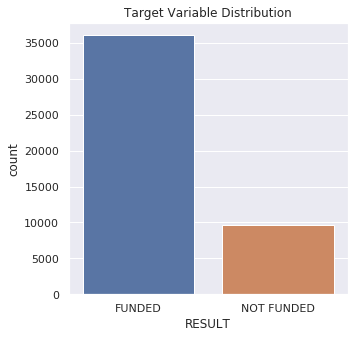

In [82]:
ax = sns.countplot(x=y, data=X_full, order=["FUNDED", "NOT FUNDED"]).set_title("Target Variable Distribution")

#### Analysis for categorical features (barplot, univariate analysis, bivariate analysis)

In [0]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [84]:
cat = X_full[categorical_cols]
cat.columns


Index(['MORTGAGE_PURPOSE', 'PAYMENT_FREQUENCY', 'PROPERTY_TYPE', 'AGE_RANGE',
       'GENDER', 'GENDER_', 'INCOME_TYPE_'],
      dtype='object')

In [85]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 7 columns):
MORTGAGE_PURPOSE     45642 non-null object
PAYMENT_FREQUENCY    45642 non-null object
PROPERTY_TYPE        45642 non-null object
AGE_RANGE            45642 non-null object
GENDER               45642 non-null object
GENDER_              45642 non-null object
INCOME_TYPE_         45642 non-null object
dtypes: object(7)
memory usage: 2.4+ MB


col_0             count  frequency
MORTGAGE_PURPOSE                  
Purchase          24419   0.535012
Refinance         21223   0.464988


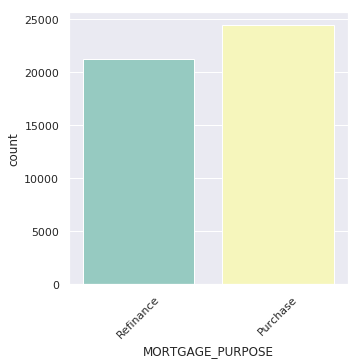

col_0                  count  frequency
PAYMENT_FREQUENCY                      
Bi-Weekly               1803   0.039503
Bi-Weekly Accelerated   1047   0.022939
Monthly                42785   0.937404
Semi-Monthly               4   0.000088
Weekly                     2   0.000044
Weekly Accelerated         1   0.000022


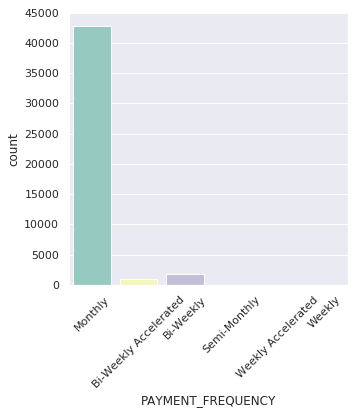

col_0                  count  frequency
PROPERTY_TYPE                          
Duplex                   469   0.010276
Fourplex                 118   0.002585
High Rise               5909   0.129464
Semi-Detached           4227   0.092612
Single Detached        29377   0.643640
Townhouse Condominium   2309   0.050589
Townhouse Freehold      3040   0.066605
Triplex                  193   0.004229


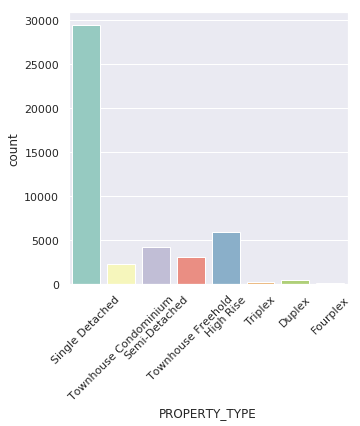

col_0        count  frequency
AGE_RANGE                    
25-29         2534   0.055519
30-34         4551   0.099711
35-39         5818   0.127470
40-44         6877   0.150673
45-49         7645   0.167499
50-54         6801   0.149007
55-59         4710   0.103194
60-64         2816   0.061698
65-69         1678   0.036764
70 and over   1374   0.030104
Under 25       838   0.018360


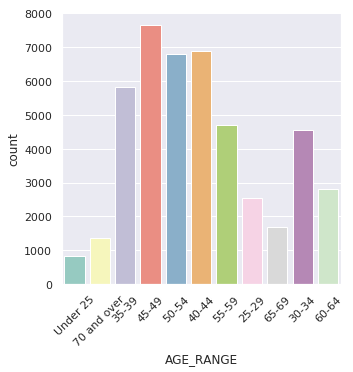

col_0   count  frequency
GENDER                  
Female  14375   0.314951
Male    31267   0.685049


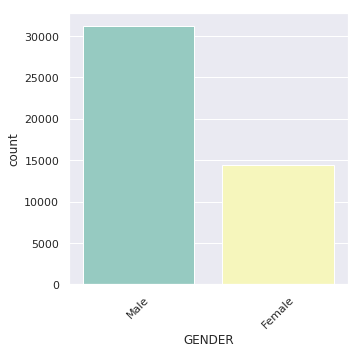

In [86]:
sns.set( rc = {'figure.figsize': (5, 5)})
fcat = ['MORTGAGE_PURPOSE','PAYMENT_FREQUENCY','PROPERTY_TYPE','AGE_RANGE','GENDER']

for col in fcat:
    count = pd.crosstab(index = cat[col], columns="count")
    percentage = pd.crosstab(index = cat[col], columns="frequency")/pd.crosstab(index = cat[col], columns="frequency").sum()
    tab = pd.concat([count, percentage], axis=1)
    plt.figure()
    sns.countplot(x=cat[col], data=cat, palette="Set3")
    plt.xticks(rotation=45)
    print(tab)
    plt.show()
    

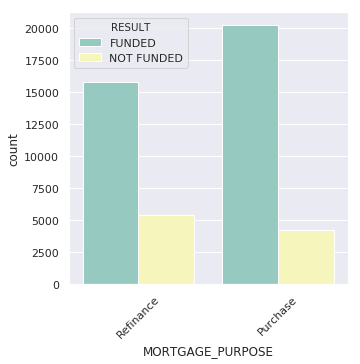

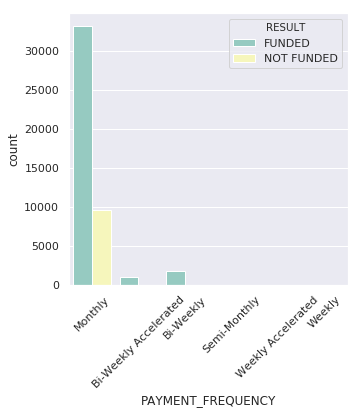

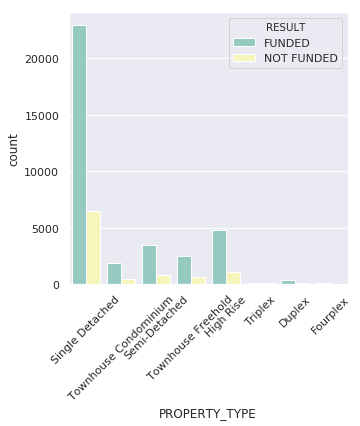

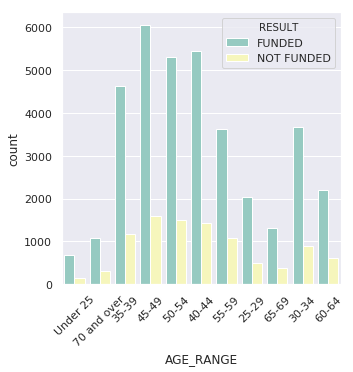

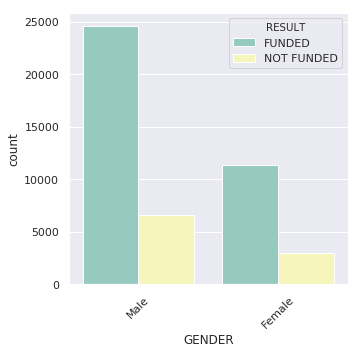

In [87]:
sns.set( rc = {'figure.figsize': (5, 5)})
fcat = ['MORTGAGE_PURPOSE','PAYMENT_FREQUENCY','PROPERTY_TYPE','AGE_RANGE','GENDER']

for col in fcat:
    plt.figure()
    sns.countplot(x=cat[col], hue=y, data=cat, palette="Set3")
    plt.xticks(rotation=45)
    plt.show()

#### Feature selection

In [0]:
cat2 = pd.concat([y,cat], axis=1)

In [0]:
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)


In [90]:
#Initialize ChiSquare Class
cT = ChiSquare(cat2)

#Feature Selection
testColumns = ['MORTGAGE_PURPOSE','PAYMENT_FREQUENCY','PROPERTY_TYPE','AGE_RANGE','GENDER','GENDER_','INCOME_TYPE_']
for var in testColumns:
    cT.TestIndependence(colX=var,colY='RESULT')  

MORTGAGE_PURPOSE is IMPORTANT for Prediction
PAYMENT_FREQUENCY is IMPORTANT for Prediction
PROPERTY_TYPE is IMPORTANT for Prediction
AGE_RANGE is IMPORTANT for Prediction
GENDER is NOT an important predictor. (Discard GENDER from model)
GENDER_ is IMPORTANT for Prediction
INCOME_TYPE_ is NOT an important predictor. (Discard INCOME_TYPE_ from model)


In [91]:
# Drop feature not helpful by Feature Selection
cat = cat.drop(['GENDER', 'INCOME_TYPE_'], axis=1)
cat.shape

(45642, 5)

#### Feature Engineering on Categorical Features: One-hot encoding

In [0]:
# One-hot encode the data (to shorten the code, I use pandas)
HOcat = pd.get_dummies(cat)
HOcat = HOcat.astype(int)


In [93]:
HOcat.head()

,MORTGAGE_PURPOSE_Purchase,MORTGAGE_PURPOSE_Refinance,PAYMENT_FREQUENCY_Bi-Weekly,PAYMENT_FREQUENCY_Bi-Weekly Accelerated,PAYMENT_FREQUENCY_Monthly,PAYMENT_FREQUENCY_Semi-Monthly,PAYMENT_FREQUENCY_Weekly,PAYMENT_FREQUENCY_Weekly Accelerated,PROPERTY_TYPE_Duplex,PROPERTY_TYPE_Fourplex,PROPERTY_TYPE_High Rise,PROPERTY_TYPE_Semi-Detached,PROPERTY_TYPE_Single Detached,PROPERTY_TYPE_Townhouse Condominium,PROPERTY_TYPE_Townhouse Freehold,PROPERTY_TYPE_Triplex,AGE_RANGE_25-29,AGE_RANGE_30-34,AGE_RANGE_35-39,AGE_RANGE_40-44,AGE_RANGE_45-49,AGE_RANGE_50-54,AGE_RANGE_55-59,AGE_RANGE_60-64,AGE_RANGE_65-69,AGE_RANGE_70 and over,AGE_RANGE_Under 25,GENDER__0,GENDER__1
0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


### Analysis for numerical features (distribution, univariate analysis, bivariate analysis)

In [0]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64']]



In [95]:
num = X_full[numerical_cols]
num.columns

Index(['PROPERTY_VALUE', 'MORTGAGE_PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE_AMOUNT', 'RATE', 'TERM', 'INCOME',
       'INCOME_TYPE', 'CREDIT_SCORE'],
      dtype='object')

In [96]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 12 columns):
PROPERTY_VALUE      45642 non-null float64
MORTGAGE_PAYMENT    45642 non-null float64
GDS                 45642 non-null float64
LTV                 45642 non-null float64
TDS                 45642 non-null float64
AMORTIZATION        45642 non-null float64
MORTGAGE_AMOUNT     45642 non-null float64
RATE                45642 non-null float64
TERM                45642 non-null float64
INCOME              45642 non-null float64
INCOME_TYPE         45642 non-null float64
CREDIT_SCORE        45642 non-null float64
dtypes: float64(12)
memory usage: 4.2 MB


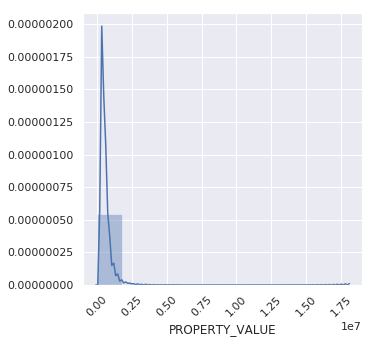

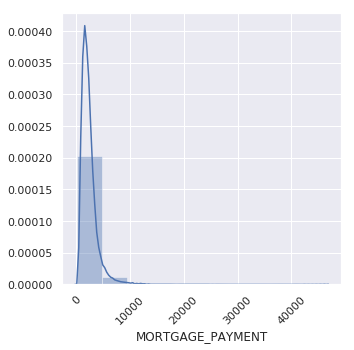

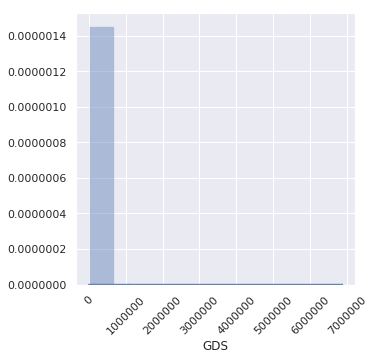

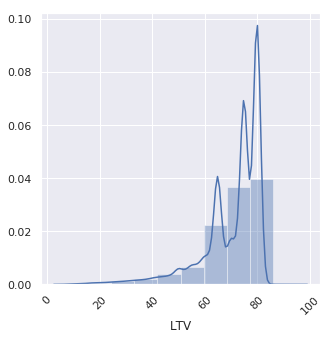

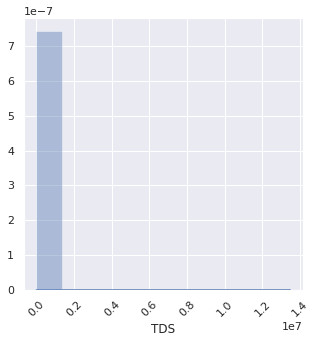

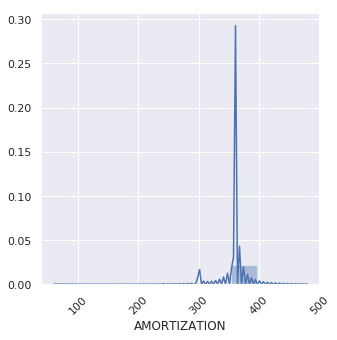

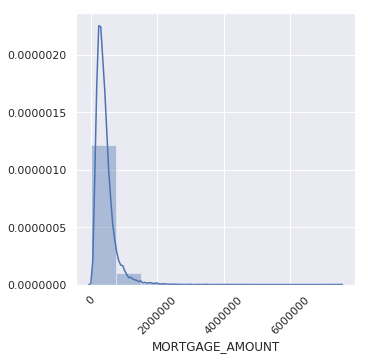

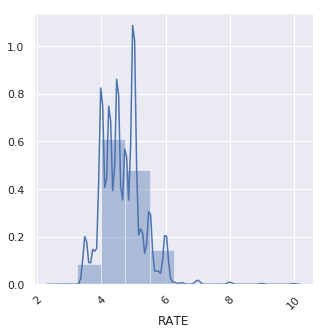

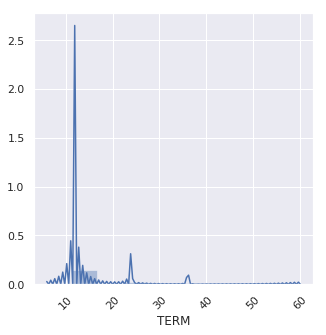

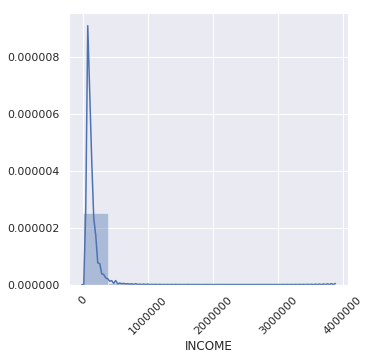

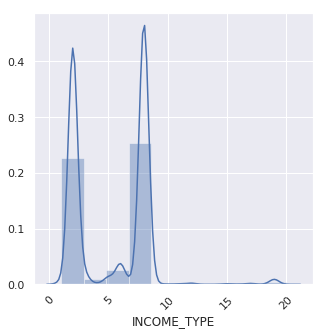

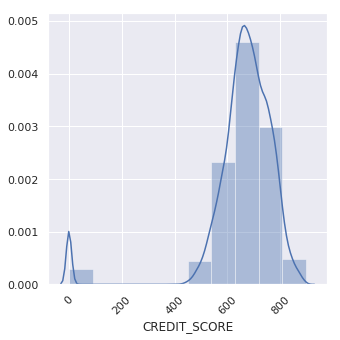

In [97]:
sns.set( rc = {'figure.figsize': (5, 5)})
fnum = ['PROPERTY_VALUE', 'MORTGAGE_PAYMENT','GDS', 'LTV', 'TDS', 'AMORTIZATION','MORTGAGE_AMOUNT', 'RATE', 'TERM', 'INCOME', 'INCOME_TYPE', 'CREDIT_SCORE']

for col in fnum:
    plt.figure()
    x=num[col]
    sns.distplot(x, bins=10)
    plt.xticks(rotation=45)
    plt.show()        

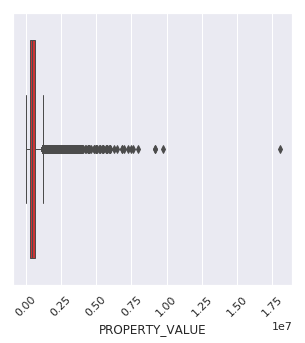

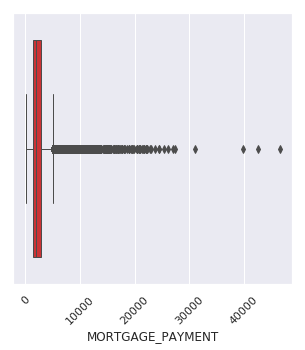

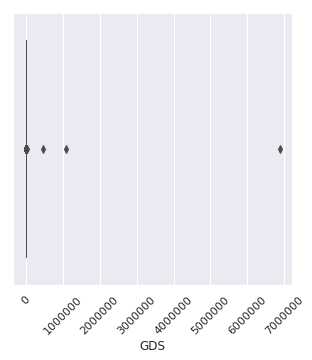

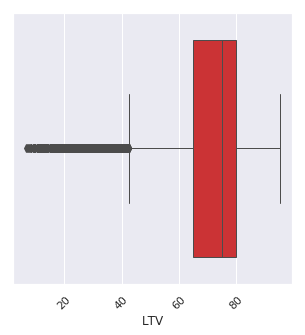

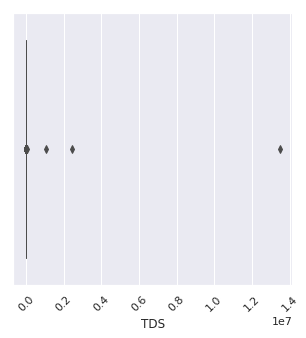

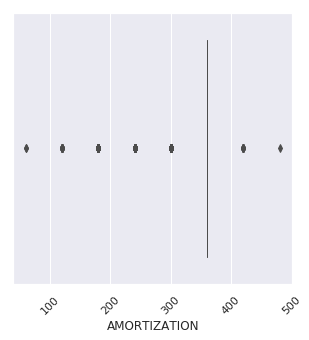

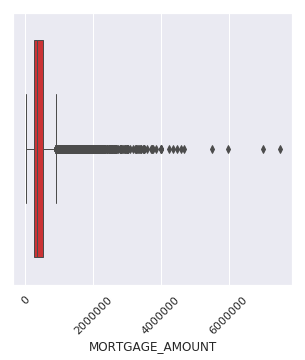

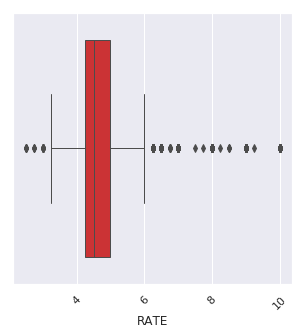

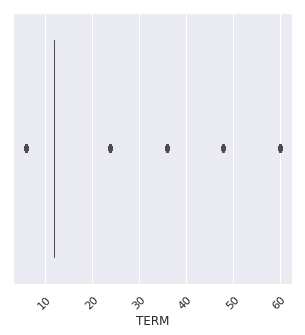

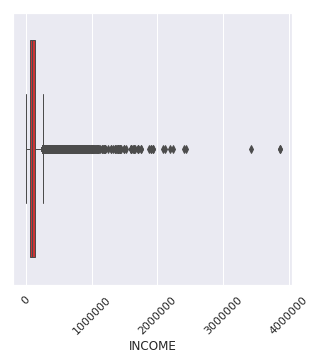

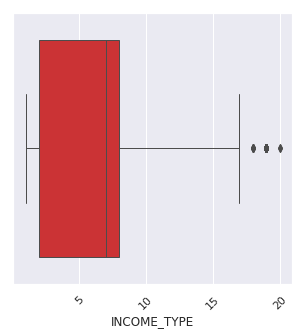

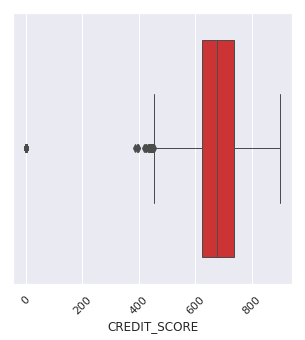

In [98]:
for col in fnum:
    plt.figure()
    x=num[col]
    sns.boxplot(x,palette="Set1",linewidth=1)
    plt.xticks(rotation=45)
    plt.show()

#### Feature selection

In [0]:
# Anova Test 
num2 = pd.concat([y,num], axis=1)
num2['RESULT'] = np.where(num2['RESULT']=='FUNDED',1,0)

In [0]:
#num2 = num2.rename(columns={"PROPERTY VALUE": "PROPERTY_VALUE","MORTGAGE PAYMENT": "MORTGAGE_PAYMENT","MORTGAGE AMOUNT":"MORTGAGE_AMOUNT",
#                           "INCOME TYPE":"INCOME_TYPE","CREDIT SCORE":"CREDIT_SCORE"})

In [101]:
results = ols('RESULT ~ PROPERTY_VALUE+MORTGAGE_PAYMENT+GDS+LTV+TDS+AMORTIZATION+MORTGAGE_AMOUNT+RATE+TERM+INCOME+INCOME_TYPE+CREDIT_SCORE', data=num2).fit()
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
PROPERTY_VALUE,0.556625,1.0,3.412226,6.472157e-02
MORTGAGE_PAYMENT,10.966403,1.0,67.226313,2.483058e-16
GDS,0.000239,1.0,0.001466,9.694578e-01
LTV,21.345510,1.0,130.852378,2.933207e-30
TDS,0.005464,1.0,0.033494,8.547877e-01
AMORTIZATION,0.076748,1.0,0.470482,4.927690e-01
MORTGAGE_AMOUNT,0.016041,1.0,0.098332,7.538419e-01
RATE,31.734652,1.0,194.539962,4.000693e-44
TERM,0.790803,1.0,4.847784,2.768665e-02
INCOME,5.646870,1.0,34.616479,4.042878e-09


#### Handling Outliers

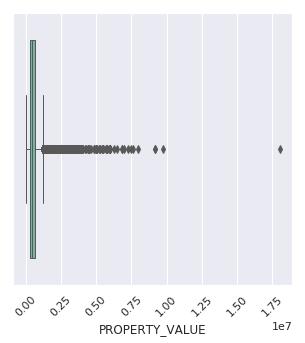

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


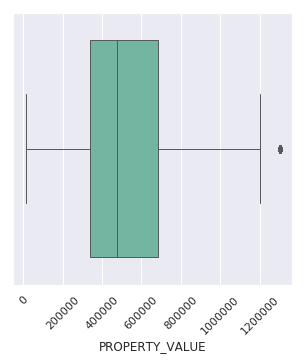

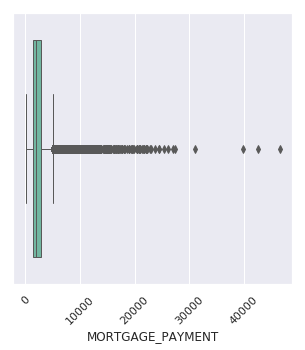

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


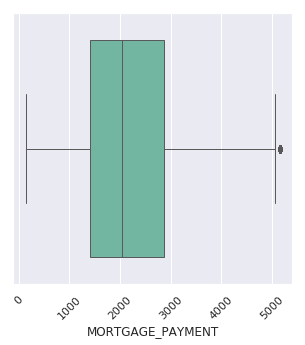

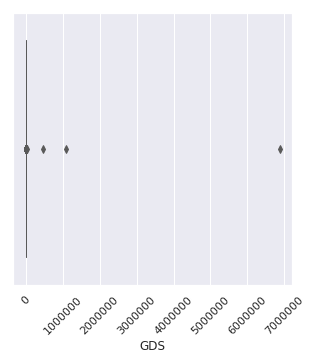

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


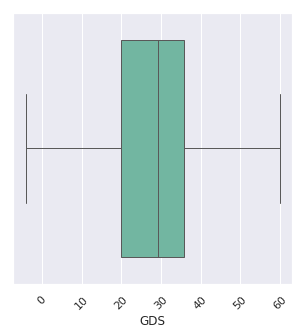

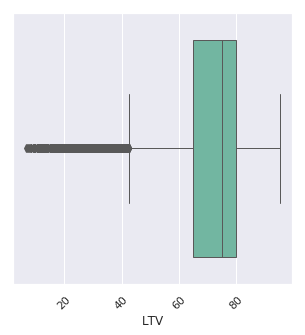

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


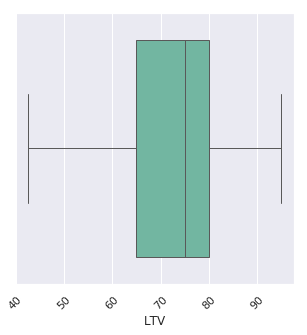

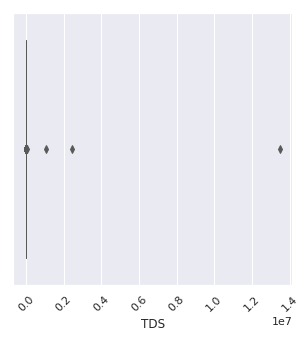

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


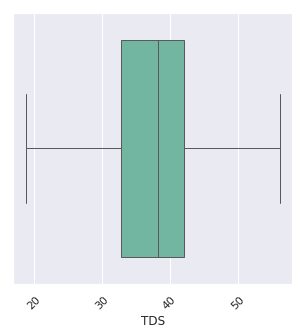

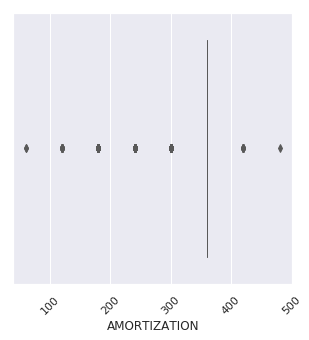

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


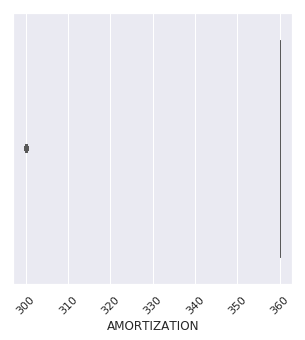

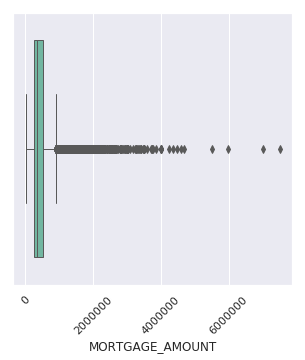

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


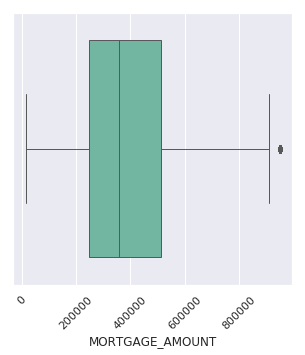

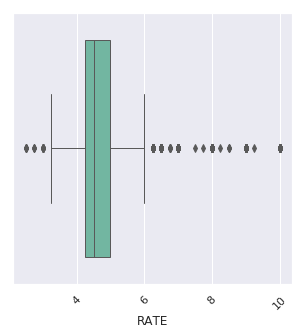

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


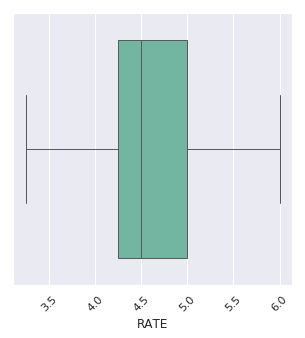

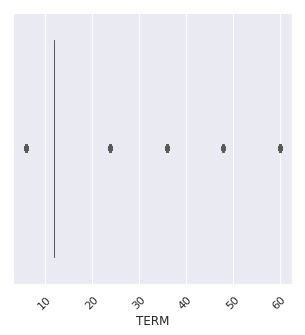

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


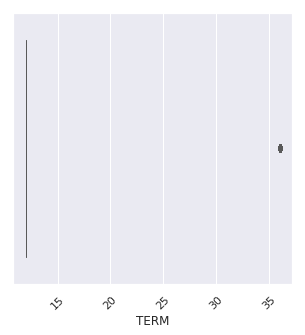

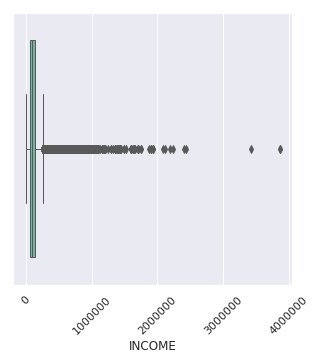

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


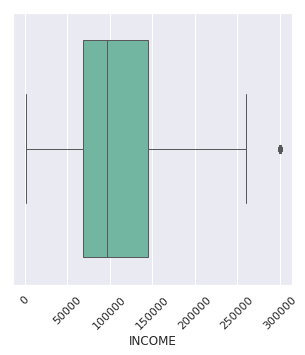

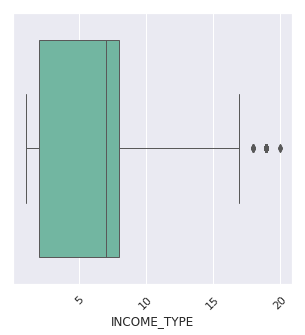

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


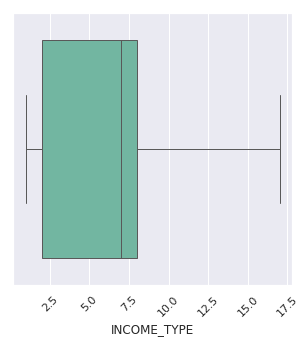

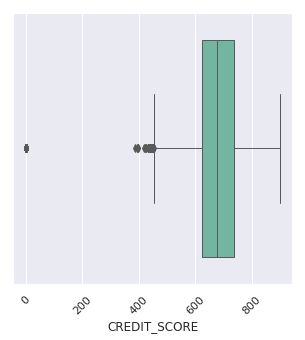

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


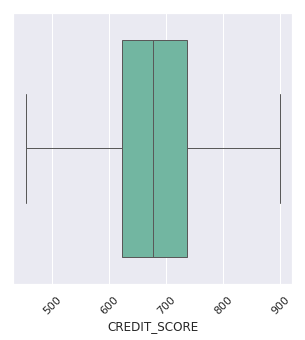

In [102]:
# Outliers

# PROPERTY_VALUE
#before
plt.figure()
x=num['PROPERTY_VALUE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'PROPERTY_VALUE'
q75, q25 = np.percentile(num.PROPERTY_VALUE.dropna(), [75 ,25])
q95, q05 = np.percentile(num.PROPERTY_VALUE.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['PROPERTY_VALUE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# MORTGAGE_PAYMENT
#before
plt.figure()
x=num['MORTGAGE_PAYMENT']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'MORTGAGE_PAYMENT'
q75, q25 = np.percentile(num.MORTGAGE_PAYMENT.dropna(), [75 ,25])
q95, q05 = np.percentile(num.MORTGAGE_PAYMENT.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['MORTGAGE_PAYMENT']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# GDS
#before
plt.figure()
x=num['GDS']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'GDS'
q75, q25 = np.percentile(num.GDS.dropna(), [75 ,25])
q95, q05 = np.percentile(num.GDS.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['GDS']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# LTV
#before
plt.figure()
x=num['LTV']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'LTV'
q75, q25 = np.percentile(num.LTV.dropna(), [75 ,25])
q95, q05 = np.percentile(num.LTV.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['LTV']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# TDS
#before
plt.figure()
x=num['TDS']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'TDS'
q75, q25 = np.percentile(num.TDS.dropna(), [75 ,25])
q95, q05 = np.percentile(num.TDS.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['TDS']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# AMORTIZATION
#before
plt.figure()
x=num['AMORTIZATION']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'AMORTIZATION'
q75, q25 = np.percentile(num.AMORTIZATION.dropna(), [75 ,25])
q95, q05 = np.percentile(num.AMORTIZATION.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['AMORTIZATION']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# MORTGAGE_AMOUNT
#before
plt.figure()
x=num['MORTGAGE_AMOUNT']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'MORTGAGE_AMOUNT'
q75, q25 = np.percentile(num.MORTGAGE_AMOUNT.dropna(), [75 ,25])
q95, q05 = np.percentile(num.MORTGAGE_AMOUNT.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['MORTGAGE_AMOUNT']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# RATE
#before
plt.figure()
x=num['RATE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'RATE'
q75, q25 = np.percentile(num.RATE.dropna(), [75 ,25])
q95, q05 = np.percentile(num.RATE.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['RATE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# TERM
#before
plt.figure()
x=num['TERM']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'TERM'
q75, q25 = np.percentile(num.TERM.dropna(), [75 ,25])
q95, q05 = np.percentile(num.TERM.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['TERM']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# INCOME
#before
plt.figure()
x=num['INCOME']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'INCOME'
q75, q25 = np.percentile(num.INCOME.dropna(), [75 ,25])
q95, q05 = np.percentile(num.INCOME.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['INCOME']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# INCOME_TYPE
#before
plt.figure()
x=num['INCOME_TYPE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'INCOME_TYPE'
q75, q25 = np.percentile(num.INCOME_TYPE.dropna(), [75 ,25])
q95, q05 = np.percentile(num.INCOME_TYPE.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['INCOME_TYPE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()


# CREDIT_SCORE
#before
plt.figure()
x=num['CREDIT_SCORE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()

#corrections
i = 'CREDIT_SCORE'
q75, q25 = np.percentile(num.CREDIT_SCORE.dropna(), [75 ,25])
q95, q05 = np.percentile(num.CREDIT_SCORE.dropna(), [95 ,5])
iqr = q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5) 
num[i].loc[num[i] < min] = q05
num[i].loc[num[i] > max] = q95

#after
plt.figure()
x=num['CREDIT_SCORE']
sns.boxplot(x,palette="Set2",linewidth=1)
plt.xticks(rotation=45)
plt.show()



#### Feature Engineering on Numerical Features

In [0]:
#polynomial features
poly_num2 = []
poly_num3 = []


for f in numerical_cols:
  poly_num2 = num[numerical_cols]**2
  poly_num3 = num[numerical_cols]**3
  poly_num2.columns = [col + '_2' for col in num.columns]
  poly_num3.columns = [col + '_3' for col in num.columns]
  poly_num2.append(numerical_cols)
  poly_num3.append(numerical_cols)
  


In [0]:
poly_num = pd.concat([num, poly_num2, poly_num3], axis=1, join='inner')

In [105]:
poly_num.head()

,PROPERTY_VALUE,MORTGAGE_PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE_AMOUNT,RATE,TERM,INCOME,INCOME_TYPE,CREDIT_SCORE,PROPERTY_VALUE_2,MORTGAGE_PAYMENT_2,GDS_2,LTV_2,TDS_2,AMORTIZATION_2,MORTGAGE_AMOUNT_2,RATE_2,TERM_2,INCOME_2,INCOME_TYPE_2,CREDIT_SCORE_2,PROPERTY_VALUE_3,MORTGAGE_PAYMENT_3,GDS_3,LTV_3,TDS_3,AMORTIZATION_3,MORTGAGE_AMOUNT_3,RATE_3,TERM_3,INCOME_3,INCOME_TYPE_3,CREDIT_SCORE_3
0,900000.0,5146.95,44.89,65.00,51.78,360.0,950000.0,4.0,12.0,108000.0,8.0,681.0,8.100000e+11,2.649109e+07,2015.1121,4225.0000,2681.1684,129600.0,9.025000e+11,16.00,144.0,1.166400e+10,64.0,463761.0,7.290000e+17,1.363483e+11,90458.382169,274625.000000,138830.899752,46656000.0,8.573750e+17,64.000,1728.0,1.259712e+15,512.0,315821241.0
1,386000.0,2179.00,35.22,74.29,40.65,360.0,390000.0,4.5,12.0,78000.0,2.0,710.0,1.489960e+11,4.748041e+06,1240.4484,5519.0041,1652.4225,129600.0,1.521000e+11,20.25,144.0,6.084000e+09,4.0,504100.0,5.751246e+16,1.034598e+10,43688.592648,410006.814589,67170.974625,46656000.0,5.931900e+16,91.125,1728.0,4.745520e+14,8.0,357911000.0
2,531000.0,2152.00,30.97,80.00,35.41,360.0,424800.0,3.5,12.0,87000.0,2.0,709.0,2.819610e+11,4.631104e+06,959.1409,6400.0000,1253.8681,129600.0,1.804550e+11,12.25,144.0,7.569000e+09,4.0,502681.0,1.497213e+17,9.966136e+09,29704.593673,512000.000000,44399.469421,46656000.0,7.665730e+16,42.875,1728.0,6.585030e+14,8.0,356400829.0
3,1200000.0,5146.95,19.04,75.00,34.14,360.0,950000.0,5.5,12.0,300000.0,8.0,761.0,1.440000e+12,2.649109e+07,362.5216,5625.0000,1165.5396,129600.0,9.025000e+11,30.25,144.0,9.000000e+10,64.0,579121.0,1.728000e+18,1.363483e+11,6902.411264,421875.000000,39791.521944,46656000.0,8.573750e+17,166.375,1728.0,2.700000e+16,512.0,440711081.0
4,350000.0,3342.00,29.59,80.00,34.85,360.0,592000.0,5.0,12.0,147000.0,8.0,762.0,1.225000e+11,1.116896e+07,875.5681,6400.0000,1214.5225,129600.0,3.504640e+11,25.00,144.0,2.160900e+10,64.0,580644.0,4.287500e+16,3.732668e+10,25908.060079,512000.000000,42326.109125,46656000.0,2.074747e+17,125.000,1728.0,3.176523e+15,512.0,442450728.0


In [0]:
# Grasp all
X_all = pd.concat([HOcat, poly_num], axis=1, join='inner')

In [107]:
X_all.head()

,MORTGAGE_PURPOSE_Purchase,MORTGAGE_PURPOSE_Refinance,PAYMENT_FREQUENCY_Bi-Weekly,PAYMENT_FREQUENCY_Bi-Weekly Accelerated,PAYMENT_FREQUENCY_Monthly,PAYMENT_FREQUENCY_Semi-Monthly,PAYMENT_FREQUENCY_Weekly,PAYMENT_FREQUENCY_Weekly Accelerated,PROPERTY_TYPE_Duplex,PROPERTY_TYPE_Fourplex,PROPERTY_TYPE_High Rise,PROPERTY_TYPE_Semi-Detached,PROPERTY_TYPE_Single Detached,PROPERTY_TYPE_Townhouse Condominium,PROPERTY_TYPE_Townhouse Freehold,PROPERTY_TYPE_Triplex,AGE_RANGE_25-29,AGE_RANGE_30-34,AGE_RANGE_35-39,AGE_RANGE_40-44,AGE_RANGE_45-49,AGE_RANGE_50-54,AGE_RANGE_55-59,AGE_RANGE_60-64,AGE_RANGE_65-69,AGE_RANGE_70 and over,AGE_RANGE_Under 25,GENDER__0,GENDER__1,PROPERTY_VALUE,MORTGAGE_PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE_AMOUNT,RATE,TERM,INCOME,INCOME_TYPE,CREDIT_SCORE,PROPERTY_VALUE_2,MORTGAGE_PAYMENT_2,GDS_2,LTV_2,TDS_2,AMORTIZATION_2,MORTGAGE_AMOUNT_2,RATE_2,TERM_2,INCOME_2,INCOME_TYPE_2,CREDIT_SCORE_2,PROPERTY_VALUE_3,MORTGAGE_PAYMENT_3,GDS_3,LTV_3,TDS_3,AMORTIZATION_3,MORTGAGE_AMOUNT_3,RATE_3,TERM_3,INCOME_3,INCOME_TYPE_3,CREDIT_SCORE_3
0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,900000.0,5146.95,44.89,65.00,51.78,360.0,950000.0,4.0,12.0,108000.0,8.0,681.0,8.100000e+11,2.649109e+07,2015.1121,4225.0000,2681.1684,129600.0,9.025000e+11,16.00,144.0,1.166400e+10,64.0,463761.0,7.290000e+17,1.363483e+11,90458.382169,274625.000000,138830.899752,46656000.0,8.573750e+17,64.000,1728.0,1.259712e+15,512.0,315821241.0
1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,386000.0,2179.00,35.22,74.29,40.65,360.0,390000.0,4.5,12.0,78000.0,2.0,710.0,1.489960e+11,4.748041e+06,1240.4484,5519.0041,1652.4225,129600.0,1.521000e+11,20.25,144.0,6.084000e+09,4.0,504100.0,5.751246e+16,1.034598e+10,43688.592648,410006.814589,67170.974625,46656000.0,5.931900e+16,91.125,1728.0,4.745520e+14,8.0,357911000.0
2,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,531000.0,2152.00,30.97,80.00,35.41,360.0,424800.0,3.5,12.0,87000.0,2.0,709.0,2.819610e+11,4.631104e+06,959.1409,6400.0000,1253.8681,129600.0,1.804550e+11,12.25,144.0,7.569000e+09,4.0,502681.0,1.497213e+17,9.966136e+09,29704.593673,512000.000000,44399.469421,46656000.0,7.665730e+16,42.875,1728.0,6.585030e+14,8.0,356400829.0
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1200000.0,5146.95,19.04,75.00,34.14,360.0,950000.0,5.5,12.0,300000.0,8.0,761.0,1.440000e+12,2.649109e+07,362.5216,5625.0000,1165.5396,129600.0,9.025000e+11,30.25,144.0,9.000000e+10,64.0,579121.0,1.728000e+18,1.363483e+11,6902.411264,421875.000000,39791.521944,46656000.0,8.573750e+17,166.375,1728.0,2.700000e+16,512.0,440711081.0
4,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,350000.0,3342.00,29.59,80.00,34.85,360.0,592000.0,5.0,12.0,147000.0,8.0,762.0,1.225000e+11,1.116896e+07,875.5681,6400.0000,1214.5225,129600.0,3.504640e+11,25.00,144.0,2.160900e+10,64.0,580644.0,4.287500e+16,3.732668e+10,25908.060079,512000.000000,42326.109125,46656000.0,2.074747e+17,125.000,1728.0,3.176523e+15,512.0,442450728.0


In [108]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 65 columns):
MORTGAGE_PURPOSE_Purchase                  45642 non-null int64
MORTGAGE_PURPOSE_Refinance                 45642 non-null int64
PAYMENT_FREQUENCY_Bi-Weekly                45642 non-null int64
PAYMENT_FREQUENCY_Bi-Weekly Accelerated    45642 non-null int64
PAYMENT_FREQUENCY_Monthly                  45642 non-null int64
PAYMENT_FREQUENCY_Semi-Monthly             45642 non-null int64
PAYMENT_FREQUENCY_Weekly                   45642 non-null int64
PAYMENT_FREQUENCY_Weekly Accelerated       45642 non-null int64
PROPERTY_TYPE_Duplex                       45642 non-null int64
PROPERTY_TYPE_Fourplex                     45642 non-null int64
PROPERTY_TYPE_High Rise                    45642 non-null int64
PROPERTY_TYPE_Semi-Detached                45642 non-null int64
PROPERTY_TYPE_Single Detached              45642 non-null int64
PROPERTY_TYPE_Townhouse Condominium        45642 non-null i

### Modeling Part I: without handling unbalanced target variable

### Pre-Processing: split dataset

In [0]:
# Break off validation and test set from training data
X_train, X_test, y_train, y_test = train_test_split(X_all, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2,
                                                                random_state=0)


#### Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="orange")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Baseline Models

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[7240    0]
 [1889    0]]
Confusion matrix, without normalization
[[6942  298]
 [1669  220]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[6991  249]
 [1711  178]]
Confusion matrix, without normalization
[[7170   70]
 [1824   65]]
Confusion matrix, without normalization
[[7197   43]
 [1812   77]]
Confusion matrix, without normalization
[[7206   34]
 [1839   50]]


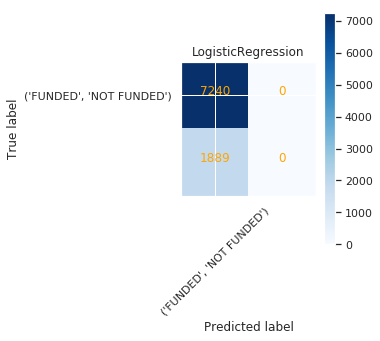

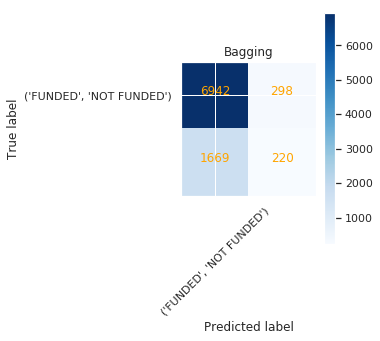

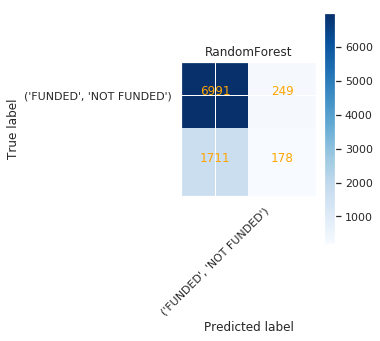

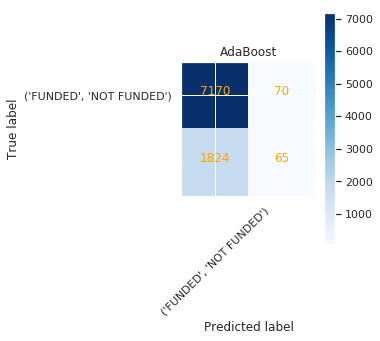

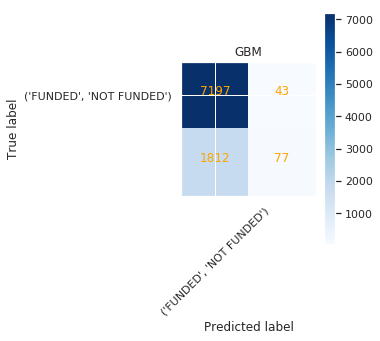

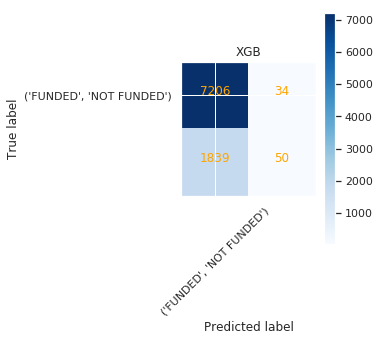

In [111]:
# Spot Check Algorithms
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=0)))
models.append(('Bagging', BaggingClassifier(random_state=0)))
models.append(('RandomForest', RandomForestClassifier(random_state=0)))
models.append(('AdaBoost', AdaBoostClassifier(random_state=0)))
models.append(('GBM', GradientBoostingClassifier(random_state=0)))
models.append(('XGB', XGBClassifier(random_state=0)))
results_tr = []
results_v = []
results_t = []
names = []
score = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in models:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_train, y_train)
    predictions_tr = my_model.predict(X_train) 
    predictions_v = my_model.predict(X_valid)
    predictions_t = my_model.predict(X_test)
    accuracy_train = accuracy_score(y_train, predictions_tr) 
    accuracy_valid = accuracy_score(y_valid, predictions_v) 
    accuracy_test = accuracy_score(y_test, predictions_t) 
    results_tr.append(accuracy_train)
    results_v.append(accuracy_valid)
    results_t.append(accuracy_test)
    
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
        'accuracy_test': accuracy_test
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_test, predictions_t)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[('FUNDED', 'NOT FUNDED')], title=""+str(name))
    score.append(f_dict)
plt.show()    
score = pd.DataFrame(score, columns = ['model','accuracy_train', 'accuracy_valid', 'accuracy_test'])

In [112]:
print(score)

                model  accuracy_train  accuracy_valid  accuracy_test
0  LogisticRegression        0.788634        0.786937       0.793077
1             Bagging        0.977302        0.778173       0.784533
2        RandomForest        0.977405        0.781870       0.785300
3            AdaBoost        0.791202        0.789402       0.792529
4                 GBM        0.796474        0.792003       0.796801
5                 XGB        0.793290        0.789812       0.794830


### Feature Importance

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'RandomForest')

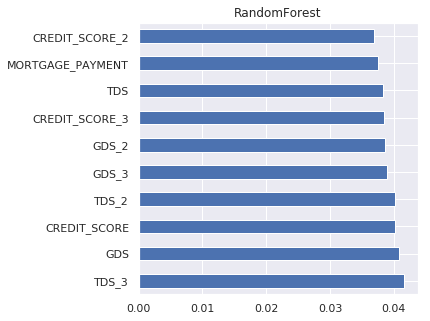

In [113]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

(pd.Series(model.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')).set_title("RandomForest")

Text(0.5, 1.0, 'AdaBoost')

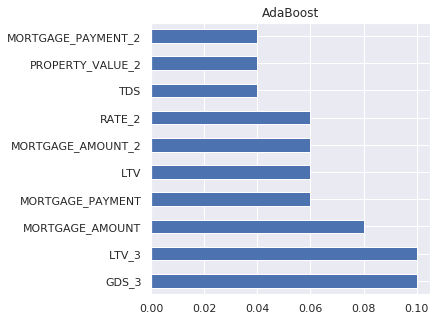

In [114]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)

(pd.Series(model.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')).set_title("AdaBoost")

Text(0.5, 1.0, 'GBM')

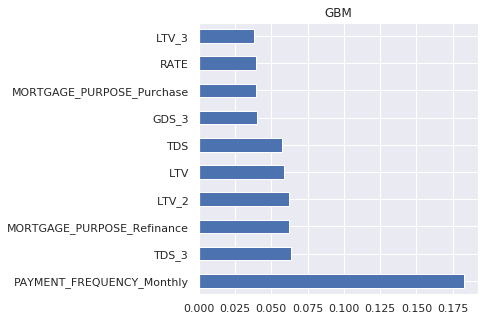

In [115]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

(pd.Series(model.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')).set_title("GBM")

Text(0.5, 1.0, 'XGB')

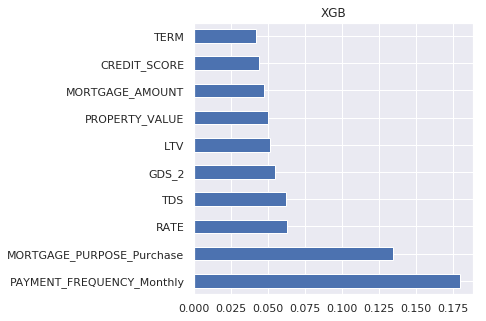

In [116]:
model = XGBClassifier()
model.fit(X_train, y_train)

(pd.Series(model.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')).set_title("XGB")

### Scaled Baseline Models

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[7164   76]
 [1825   64]]
Confusion matrix, without normalization
[[6917  323]
 [1678  211]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[7005  235]
 [1720  169]]
Confusion matrix, without normalization
[[7170   70]
 [1824   65]]
Confusion matrix, without normalization
[[7197   43]
 [1812   77]]
Confusion matrix, without normalization
[[7206   34]
 [1839   50]]


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

Confusion matrix, without normalization
[[6671  569]
 [1562  327]]


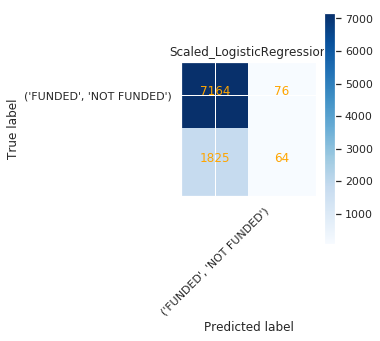

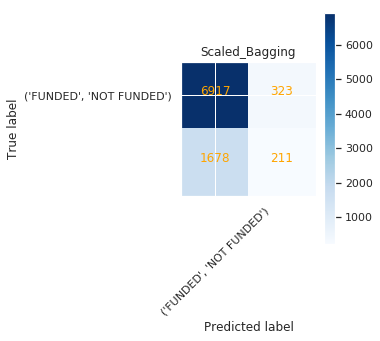

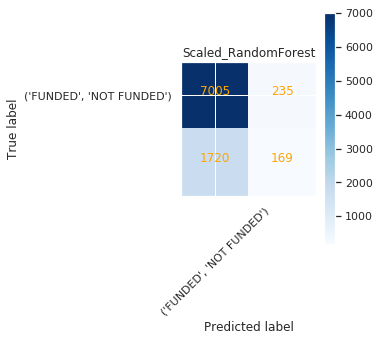

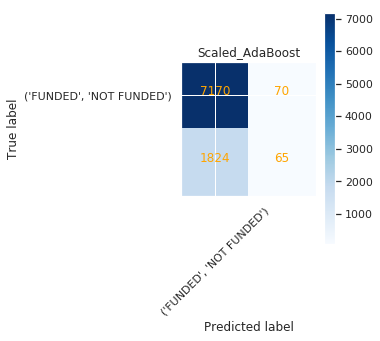

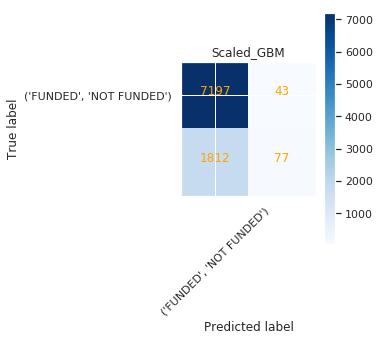

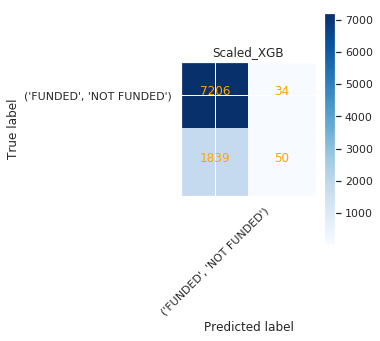

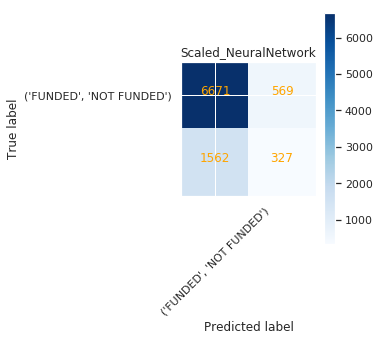

In [117]:
# Spot Check Algorithms with standardized dataset
pipelines = []
pipelines.append(('Scaled_LogisticRegression', Pipeline([('Scaler', StandardScaler()),('LogisticRegression', LogisticRegression(random_state=0))])))
pipelines.append(('Scaled_Bagging', Pipeline([('Scaler', StandardScaler()),('Bagging', BaggingClassifier(random_state=0))])))
pipelines.append(('Scaled_RandomForest', Pipeline([('Scaler', StandardScaler()),('RandomForest', RandomForestClassifier(random_state=0))])))
pipelines.append(('Scaled_AdaBoost', Pipeline([('Scaler', StandardScaler()),('AdaBoost', AdaBoostClassifier(random_state=0))])))
pipelines.append(('Scaled_GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(random_state=0))])))
pipelines.append(('Scaled_XGB', Pipeline([('Scaler', StandardScaler()),('XGB', XGBClassifier(random_state=0))])))
pipelines.append(('Scaled_NeuralNetwork', Pipeline([('Scaler', StandardScaler()),('NeuralNetwork', MLPClassifier(random_state=0))])))
results_tr = []
results_v = []
results_t = []
names = []
score_sd = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in pipelines:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_train, y_train)
    predictions_tr = my_model.predict(X_train) 
    predictions_v = my_model.predict(X_valid)
    predictions_t = my_model.predict(X_test)
    accuracy_train = accuracy_score(y_train, predictions_tr) 
    accuracy_valid = accuracy_score(y_valid, predictions_v) 
    accuracy_test = accuracy_score(y_test, predictions_t)
    results_tr.append(accuracy_train)
    results_v.append(accuracy_valid)
    results_t.append(accuracy_test)
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
        'accuracy_test': accuracy_test
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_test, predictions_t)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[('FUNDED','NOT FUNDED')], title=""+str(name))
    score_sd.append(f_dict)
plt.show()   
score_sd = pd.DataFrame(score_sd, columns = ['model','accuracy_train', 'accuracy_valid','accuracy_test'])

In [118]:
print(score_sd)

                       model  accuracy_train  accuracy_valid  accuracy_test
0  Scaled_LogisticRegression        0.788942        0.786663       0.791763
1             Scaled_Bagging        0.977850        0.775161       0.780808
2        Scaled_RandomForest        0.977542        0.782144       0.785847
3            Scaled_AdaBoost        0.791202        0.789402       0.792529
4                 Scaled_GBM        0.796474        0.792003       0.796801
5                 Scaled_XGB        0.793290        0.789812       0.794830
6       Scaled_NeuralNetwork        0.829647        0.760236       0.766568


### Modeling Part II: handling unbalanced target variable

### Pre-processing

#### Oversampling

In [119]:
# oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_all, y)
print(sorted(Counter(y_resampled).items()))

[('FUNDED', 36023), ('NOT FUNDED', 36023)]


#### Split dataset

In [0]:
# Break off validation and test set from training data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.8, test_size=0.2,
                                                                random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2,
                                                                random_state=0)

### Baseline Models

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[1409 5824]
 [1172 6005]]
Confusion matrix, without normalization
[[6228 1005]
 [ 609 6568]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[6299  934]
 [ 591 6586]]
Confusion matrix, without normalization
[[4365 2868]
 [2420 4757]]
Confusion matrix, without normalization
[[4471 2762]
 [2386 4791]]
Confusion matrix, without normalization
[[4434 2799]
 [2341 4836]]


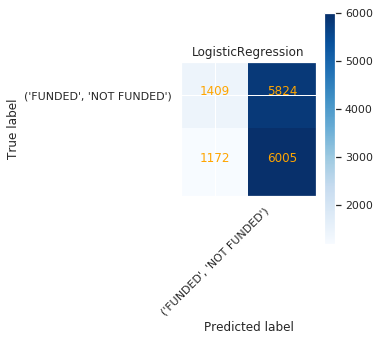

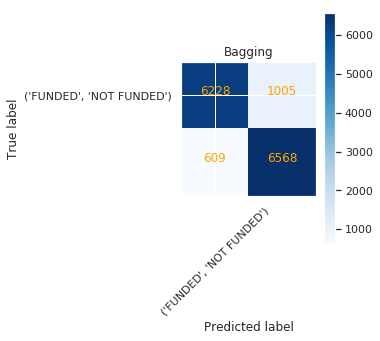

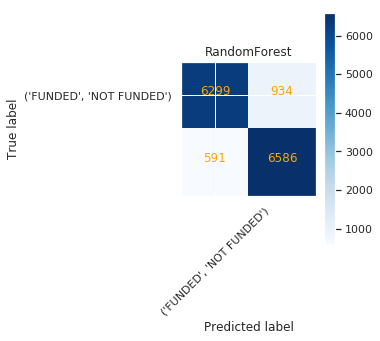

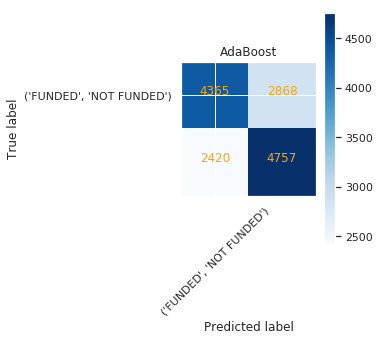

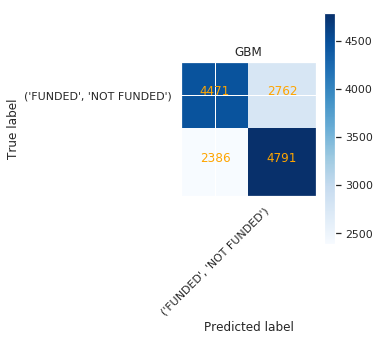

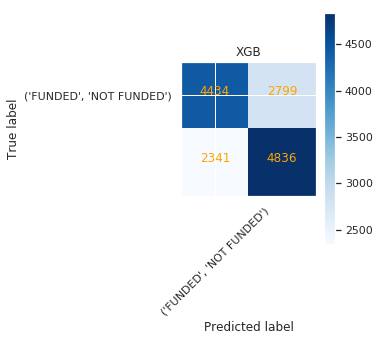

In [121]:
# Spot Check Algorithms
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=0)))
models.append(('Bagging', BaggingClassifier(random_state=0)))
models.append(('RandomForest', RandomForestClassifier(random_state=0)))
models.append(('AdaBoost', AdaBoostClassifier(random_state=0)))
models.append(('GBM', GradientBoostingClassifier(random_state=0)))
models.append(('XGB', XGBClassifier(random_state=0)))
results_tr = []
results_v = []
results_t = []
names = []
score = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in models:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_train, y_train)
    predictions_tr = my_model.predict(X_train) 
    predictions_v = my_model.predict(X_valid)
    predictions_t = my_model.predict(X_test)
    accuracy_train = accuracy_score(y_train, predictions_tr) 
    accuracy_valid = accuracy_score(y_valid, predictions_v) 
    accuracy_test = accuracy_score(y_test, predictions_t) 
    results_tr.append(accuracy_train)
    results_v.append(accuracy_valid)
    results_t.append(accuracy_test)
    
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
        'accuracy_test': accuracy_test
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_test, predictions_t)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[('FUNDED', 'NOT FUNDED')], title=""+str(name))
    score.append(f_dict)
plt.show()    
score = pd.DataFrame(score, columns = ['model','accuracy_train', 'accuracy_valid', 'accuracy_test'])

In [122]:
print(score)

                model  accuracy_train  accuracy_valid  accuracy_test
0  LogisticRegression        0.520430        0.513706       0.514504
1             Bagging        0.996183        0.884629       0.887994
2        RandomForest        0.996031        0.887838       0.894171
3            AdaBoost        0.633860        0.623959       0.633033
4                 GBM        0.649128        0.637405       0.642748
5                 XGB        0.648109        0.637405       0.643303


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[4379 2854]
 [2442 4735]]
Confusion matrix, without normalization
[[6213 1020]
 [ 608 6569]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[6263  970]
 [ 571 6606]]
Confusion matrix, without normalization
[[4365 2868]
 [2420 4757]]
Confusion matrix, without normalization
[[4471 2762]
 [2386 4791]]
Confusion matrix, without normalization
[[4434 2799]
 [2341 4836]]


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

Confusion matrix, without normalization
[[4773 2460]
 [2254 4923]]


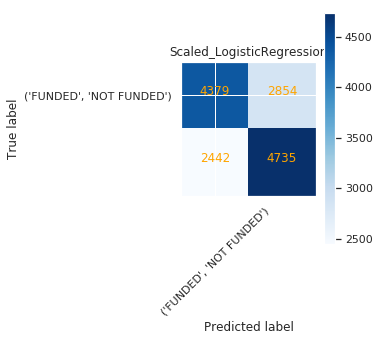

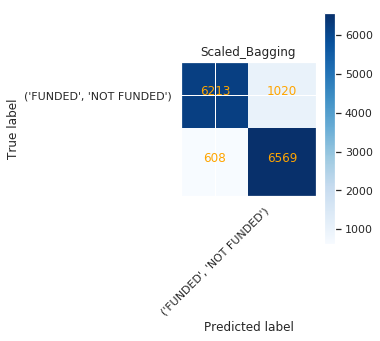

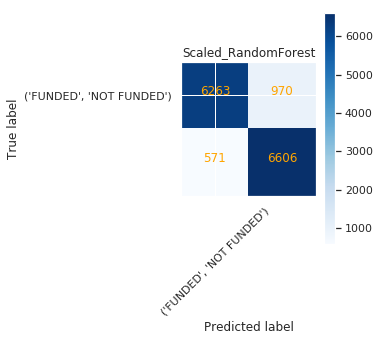

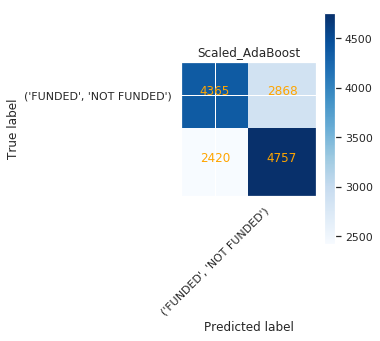

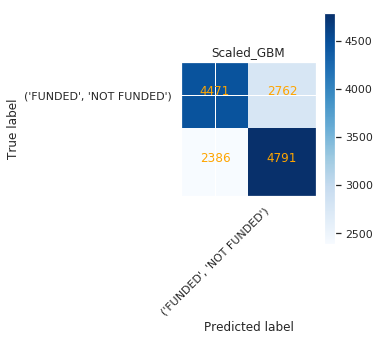

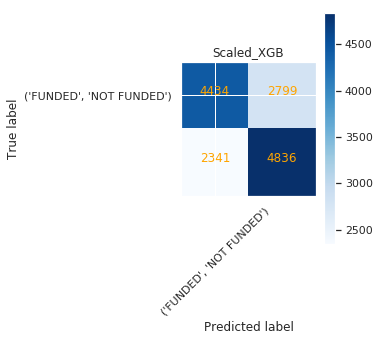

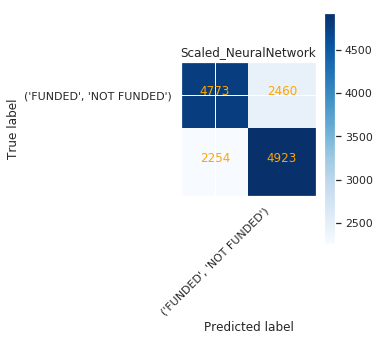

In [123]:
# Spot Check Algorithms with standardized dataset
pipelines = []
pipelines.append(('Scaled_LogisticRegression', Pipeline([('Scaler', StandardScaler()),('LogisticRegression', LogisticRegression(random_state=0))])))
pipelines.append(('Scaled_Bagging', Pipeline([('Scaler', StandardScaler()),('Bagging', BaggingClassifier(random_state=0))])))
pipelines.append(('Scaled_RandomForest', Pipeline([('Scaler', StandardScaler()),('RandomForest', RandomForestClassifier(random_state=0))])))
pipelines.append(('Scaled_AdaBoost', Pipeline([('Scaler', StandardScaler()),('AdaBoost', AdaBoostClassifier(random_state=0))])))
pipelines.append(('Scaled_GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(random_state=0))])))
pipelines.append(('Scaled_XGB', Pipeline([('Scaler', StandardScaler()),('XGB', XGBClassifier(random_state=0))])))
pipelines.append(('Scaled_NeuralNetwork', Pipeline([('Scaler', StandardScaler()),('NeuralNetwork', MLPClassifier(random_state=0))])))
results_tr = []
results_v = []
results_t = []
names = []
score_sd = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in pipelines:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_train, y_train)
    predictions_tr = my_model.predict(X_train) 
    predictions_v = my_model.predict(X_valid)
    predictions_t = my_model.predict(X_test)
    accuracy_train = accuracy_score(y_train, predictions_tr) 
    accuracy_valid = accuracy_score(y_valid, predictions_v) 
    accuracy_test = accuracy_score(y_test, predictions_t)
    results_tr.append(accuracy_train)
    results_v.append(accuracy_valid)
    results_t.append(accuracy_test)
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
        'accuracy_test': accuracy_test
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_test, predictions_t)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[('FUNDED','NOT FUNDED')], title=""+str(name))
    score_sd.append(f_dict)
plt.show()   
score_sd = pd.DataFrame(score_sd, columns = ['model','accuracy_train', 'accuracy_valid','accuracy_test'])

In [124]:
print(score_sd)

                       model  accuracy_train  accuracy_valid  accuracy_test
0  Scaled_LogisticRegression        0.629305        0.629251       0.632477
1             Scaled_Bagging        0.996096        0.883501       0.887023
2        Scaled_RandomForest        0.996356        0.890441       0.893060
3            Scaled_AdaBoost        0.633860        0.623959       0.633033
4                 Scaled_GBM        0.649128        0.637405       0.642748
5                 Scaled_XGB        0.648109        0.637405       0.643303
6       Scaled_NeuralNetwork        0.749024        0.666638       0.672866
